# Computer vision - Laboratory

==============================================================================================
## Practicum 3: Image and Video Segmentation

==============================================================================================

The main topics are:

1)	Segmentation of video shots with static scenes.

2) Background substraction.

3)	Segmentation of images.

In order to successfuly complete this practicum it is necessary to understand the following theory concepts: background substraction, K-means clustering, etc.

The following chapters of the book “Computer Vision: Algorithms and Applicatons” from Richard Szeliski have further information about the topic:

* Chapter 4: Computer Vision: Algorithms and Applications.

* Chapter 5: Segmentation.

## Imports and others...

In [1]:
from skimage import exposure 
from skimage import segmentation

In [2]:
"""
This first function allow us to display a subplot with different images

:param titles: list of the titles of each image
:param images: list of each image
:param nrows, ncolumns: number of rows and number of columns of the subplot
:return: in case of out of range
"""

def plotter(images=[],titles=[],gray=[],rows=0,cols=0):
    
    if (rows*cols) < (len(images)): #We must check if we have one cell per image
        print("Attention! The dimensions of the subplot are incorrect!")
        return
    
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 15)) #Create the subplot

    count = 0 #Index of both arrays (titles and images)
    total = len(images)
    
    for i in range(rows): #Iterate over the subplot
        for j in range(cols):
            if count<total:
                if rows == 1 and cols == 1:
                    im = axs
                elif rows==1:
                    im = axs[j]
                else:
                    im = axs[i,j]
                im.axis('off') # remove the axis values
                im.set_title(titles[count]) #Set the title
                if gray[count]:
                    im.imshow(images[count],cmap='gray')
                else:
                    im.imshow(images[count])
                
            else:
                im = axs[i,j]
                im.axis('off')
            count += 1
            
    plt.show() #Finally display the subplot

## 3.1 Background substraction methods


Given the video stored in ‘Barcelona-sequence’, which contains images acquired by a static camera, remove all the "artifacts" considered as foreground related to movement extracting the background images.

Note: One of the applications of these methods is the button "remove tourists" implemented in most commercial photo cameras. For instance, Adobe uses the "Monument Mode", which automatically deletes the people going by the cameras.

Read and visualize the sequence of images "images/Barcelona-sequence"
Hint: In order to read a  collection of images, we wil use the function animation.FuncAnimation [https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.animation.FuncAnimation.html].

Observe in the following example, how FuncAnimation is used to read and visualize a sequence of frames. Explore the parameters of animation.FuncAnimation().

<IPython.core.display.Javascript object>


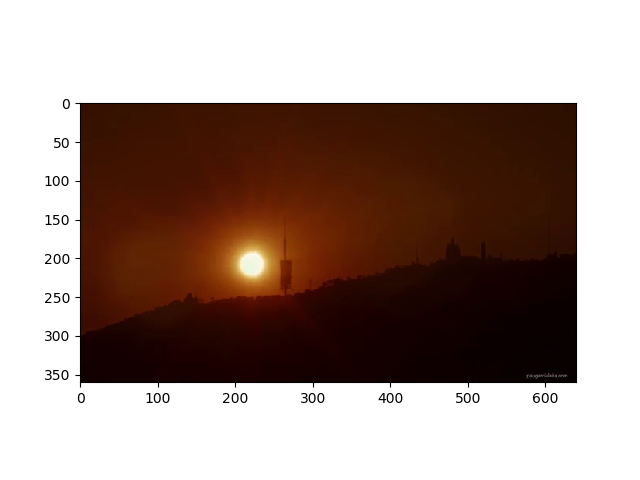

In [4]:
import numpy as np
import skimage
from skimage import io
import matplotlib.pyplot as plt

ic = io.ImageCollection('images/Barcelona-sequence/*.png')
        # Reading a sequence of images from a folder

import matplotlib.animation as animation
%matplotlib nbagg 
    #Changing the pluggin is necessary always when visualizing a video!

i=0       #Inicializing the video display
fig = plt.figure()  # Create figure
im = plt.imshow(ic[i], animated=True) #Visualize the first image

def updatefig1(i):   #Updating the frame visualization
    im.set_array(ic[i*5]) #Changing the content of the canvas
    #Generate Histograma
    return im, #to return a tuple!

ani = animation.FuncAnimation(fig, updatefig1, interval=5, blit=False, frames=50, repeat= False)

a) Find where a shot (scene) finishes and the following starts (boundaries). Each of the scenes in a video is usually called 'shot'. Which measure can be used in order to visually distinguish the shots in a plot? Explain your solution.

Show the initial and final images of each shot extracted as follows:

<img src="images_for_notebook/result_shot_detection.png">

**Hint:** take the following example of video and temporal plot visualization as a template. The plot must be replaced by a frame by frame measure to be defined by you, being applicable to distinguish the shots.

- If you need to convert the image to float, the command is: img_as_float()
- If you need the histogram, it is in skimage.exposure

<IPython.core.display.Javascript object>


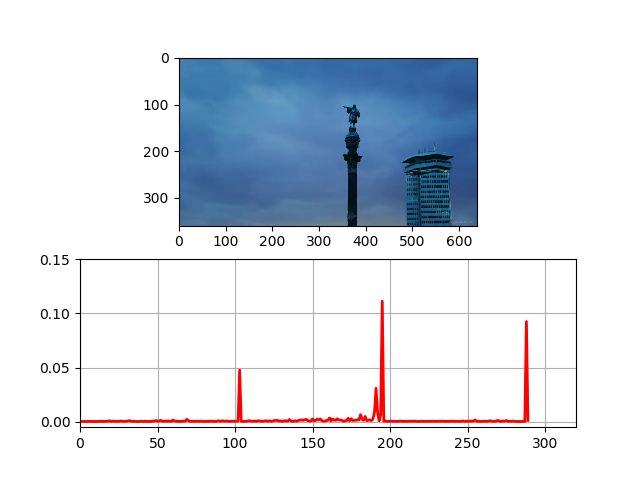

In [5]:
# Example
# Sinusoidal plot points generation
def data_gen():
    t = data_gen.t
    prev_hist = exposure.histogram(skimage.img_as_float(ic[0]), nbins=32)[0] #Array with the histogram of the first image
    for i in range(1,len(ic)):
        t += 1
        cur_hist = exposure.histogram(skimage.img_as_float(ic[i]), nbins=32)[0]
        diff = np.abs(prev_hist - cur_hist) # We need to compute the difference between the histograms of previous and the current image.
        #Then we need to update the values of the histogram
        prev_hist = cur_hist
        # Finally return the normalized mean of the differences...
        yield t, np.mean(diff/(ic[i].shape[0]*ic[i].shape[1]))
        
data_gen.t = 0

%matplotlib nbagg

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2,1)

# intialize a line object on the second axes for plotting
line, = ax2.plot([], [], lw=2, color='r')

ax2.set_ylim(-0.005,0.15)
ax2.set_xlim(0, 5)
ax2.grid()

# initialize the data arrays 
xdata, ydata = [], []

# initialize the an auxiliar array which will contains the boundaries...
aux = [(skimage.img_as_float(ic[0]),0)]

def run(data):
    # update the data plot
    t, y = data
    
    xdata.append(t) # time = x axis
    ydata.append(y) # y axis

    # Plot image on top row
    ax1.imshow(ic[len(xdata)])
    
    if y > 0.035: #If we get over the limit append the final screenshot of the previous scene and the first of 
                  #the current one...
        aux.append((skimage.img_as_float(ic[t-1]),t-1))
        aux.append((skimage.img_as_float(ic[t]),t))
        
    # Plot sin in bottom row
    xmin, xmax = ax2.get_xlim()
    if t >= xmax:
        ax2.set_xlim(xmin, 2*xmax)
        ax2.figure.canvas.draw()
            
    # update the data of both line objects
    line.set_data(xdata, ydata)
    return line

#data_gen is the parameter passed as an argument on the run function which update
#the animation and the data plot at the same time...
ani = animation.FuncAnimation(fig, run, data_gen, blit=True, interval=1, repeat=False)
plt.show()


In [6]:
try:
    from tqdm import tqdm_notebook
except:
    def tqdm_notebook(a, *_, **__): return a
    
t = -1
indices = []

# This for implements the same algorithm above but making 
# the difference for each channel without plotting/animating...

# The other parts of the exercice doesn't have any match with this cell, this is simply other way to 
# segment the video separating by channels and without ploting anything
print("Loading...")

for t in tqdm_notebook(range(len(ic)-1)):
        y = 0
        im1 = skimage.img_as_float(ic[t])
        im2 = skimage.img_as_float(ic[t+1])

        his1R, bins = skimage.exposure.histogram(im1[:,:,0],nbins=32)
        his1G, bins = skimage.exposure.histogram(im1[:,:,1],nbins=32)
        his1B, bins = skimage.exposure.histogram(im1[:,:,2],nbins=32)

        his1 = his1R+his1G+his1B

        his2R, bins = skimage.exposure.histogram(im2[:,:,0],nbins=32)
        his2G, bins = skimage.exposure.histogram(im2[:,:,1],nbins=32)
        his2B, bins = skimage.exposure.histogram(im2[:,:,2],nbins=32)

        his2 = his2R+his2G+his2B
        diff = his1-his2
        y = np.mean(np.abs(diff))
        
        if y>=10000:
            indices.append(t)
            indices.append(t+1)
            
if 0 not in indices:
    indices = [0]+indices
if len(ic)-1 not in indices:
    indices = indices+[len(ic)-1]  

print(indices)
indices = [(indices[i],indices[i+1]) for i in range(0,len(indices)-1,2)]
print(indices)

Loading...



[0, 102, 103, 194, 195, 287, 288, 289]
[(0, 102), (103, 194), (195, 287), (288, 289)]


In [7]:
#Execute this cell once the code above is executed...
aux.append((skimage.img_as_float(ic[-1]),len(ic))) #Put the final image...

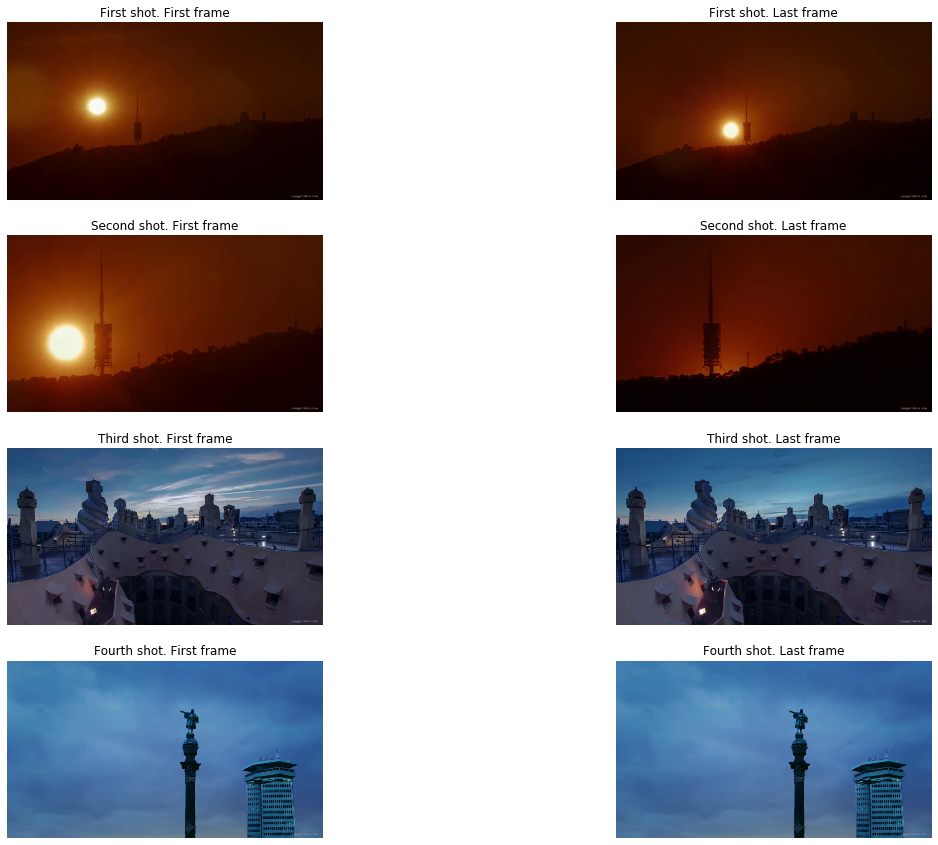

In [9]:
# Changing the pluggin and showing them on a subplot...
%matplotlib inline
plotter(images=[im[0] for im in aux], titles=["First shot. First frame", "First shot. Last frame", "Second shot. First frame", "Second shot. Last frame", 
                             "Third shot. First frame", "Third shot. Last frame", "Fourth shot. First frame", "Fourth shot. Last frame"], 
                            gray=[False for i in range(len(aux))], rows=4, cols=2)


### Answering questions

In order to implement our solution we need to do different things as we saw at theory class: detect a change of shot, save the boundaries of every shot, and finally show them.

First, we know the fact that between frames of the same scene, almost have the same values on its histogram. So as we said, to detect a change of shot, we will use the histograms of every frame, more particularly the differences between them. In data_gen function, we will take the histograms of the actual frame (remember we need first to convert its values between 0 and 1, using img_as_float) and the previous one, and we will return the value of the mean of the normalized difference as the animation goes by. Returning this value we can apreciate well the histograms changes. If we look at the grapfic below, when this value overcome a limit (in our case we set this limit at 0.035) there is a change of scene, so we've already accomplished our first objective. 

<img src="images_for_notebook/detecting_shots.png">

Once we know how to detect the changes between scenes, now we have to save the boundaries (first and last image of a scene). We will do it once we recieve the mean of the normalized difference (y) while is executing run and so data_get. If y value is greater than the limit (0.035), we add the image which is generating the difference and also the previous one (the bound of the previous scene). Finally we need to add the last pic of the animation.

To display them, we will use our plotter function (also used on the last delivery), taking the array which contains all the images. 

## 3.2 Background substraction

Apply the background substraction algorithm (check theory material).

Visualize, for each shot of the video:
    1) images belonging to the shot
    2) the background image, and
    3) the foreground.
    
**Hint**: You can construct a mask obtained from the original image and the background in order to know which parts of the image form part from the foreground and recover from the original image just the foreground regions.

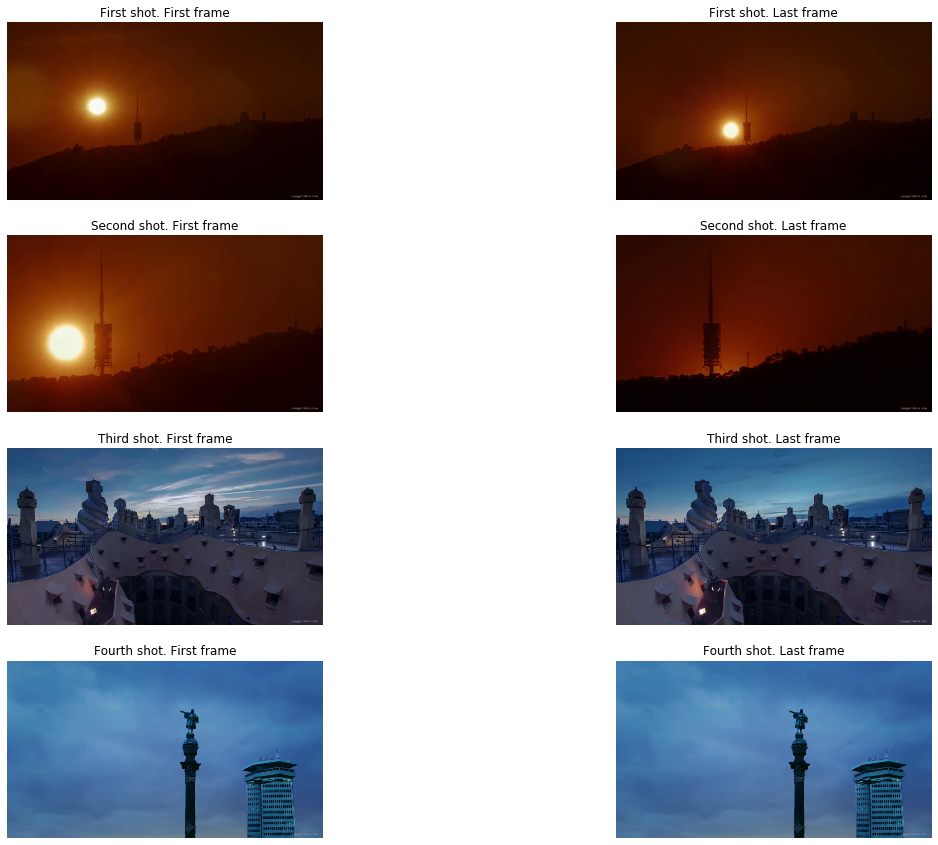

In [10]:
# 1) Images belonging to the shot
plotter(images=[im[0] for im in aux], titles=["First shot. First frame", "First shot. Last frame", "Second shot. First frame", "Second shot. Last frame", 
                             "Third shot. First frame", "Third shot. Last frame", "Fourth shot. First frame", "Fourth shot. Last frame"], 
                            gray=[False for i in range(len(aux))], rows=4, cols=2)

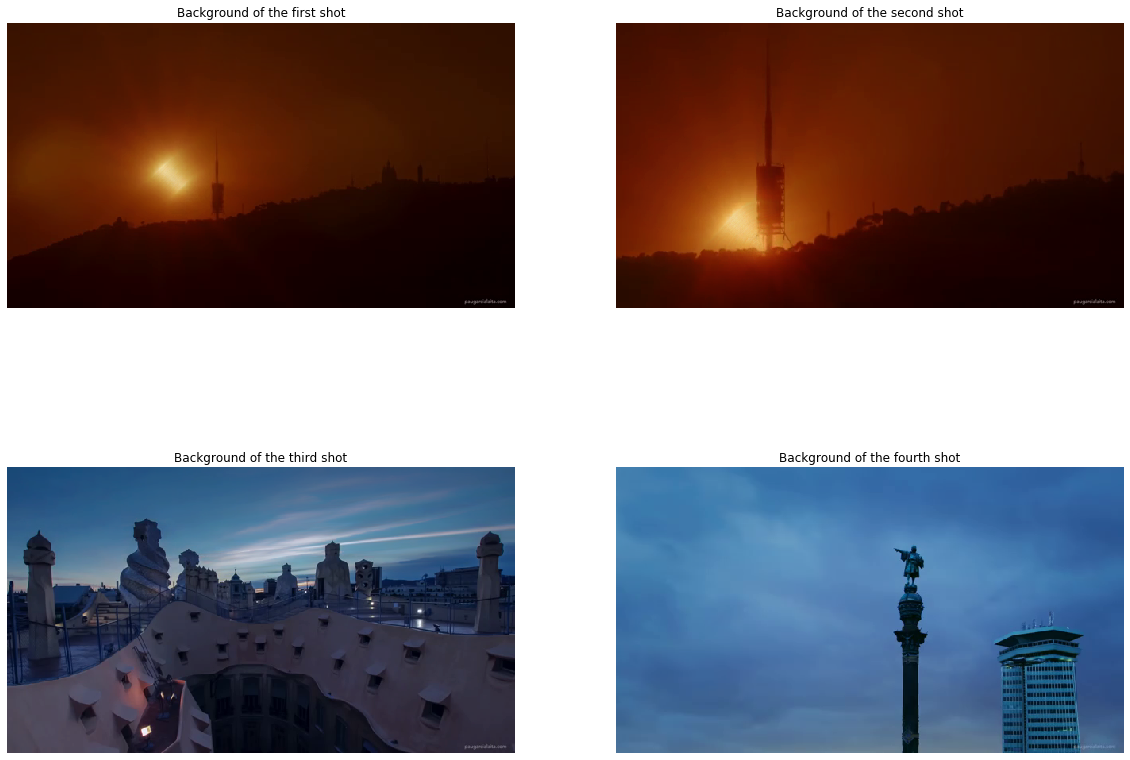

In [11]:
# 2) The background image
# We need to get all the boundaries index... 
index_list = [idx[1] for idx in aux]

# Then we will get the index of the boundaries and also the lenght of each scene
scenes = [(index_list[i],index_list[i+1]) for i in range(0,len(index_list),2)]

# This array will hold all the backgrounds...
backgrounds = []

# In this loop we will create a new image that will contain all the frames on a scene. Once we have that
# we will be able to use median filter for all the pixels of every frame and extract the background...
for scene in scenes:
    background = []
    count = 0
    for i in range(scene[0],scene[1]):
        background.append(skimage.img_as_float(ic[i]))
        count += 1 
    background = np.median(np.asarray(background), axis=0) # Apply the median filter
    backgrounds.append(background)

plotter(images=backgrounds,titles=["Background of the first shot","Background of the second shot",
                                   "Background of the third shot","Background of the fourth shot"],
                                    gray=[False for i in range(len(backgrounds))],rows=2,cols=2)

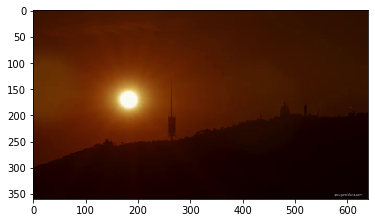

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


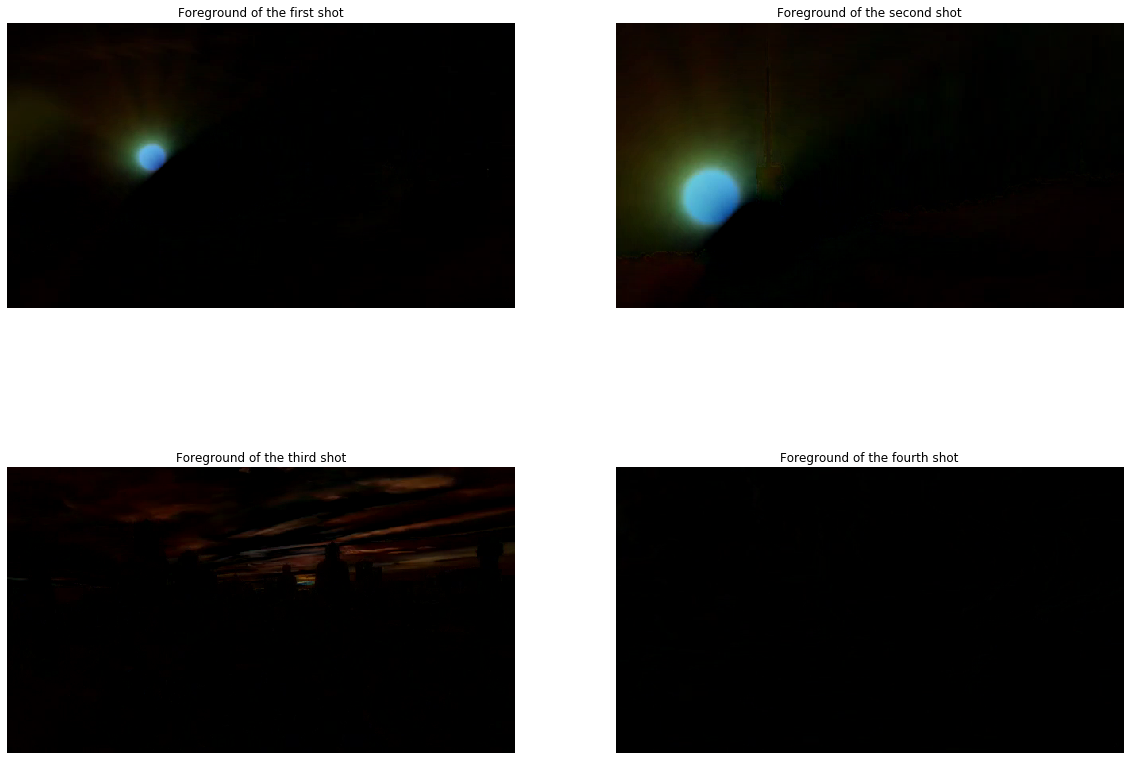

In [24]:
# 3) Foreground image
lista = []
for i in range(len(scenes)):
    lista.append(skimage.img_as_float(ic[scenes[i][0]]) - backgrounds[i])

plt.imshow(lista[0]+backgrounds[0])
plt.show()
plotter(images=lista,titles=["Foreground of the first shot","Foreground of the second shot","Foreground of the third shot","Foreground of the fourth shot"],gray=[False for i in range(len(lista))],rows=2,cols=2)

Comment your implementation including details. What happens if the shots are not correctly extracted? What happens if you find too many shots in the video? What do the static background images represent? In which situations does the algorithm work and in which it does not? What happens if you substract the background image from the original one?

Do you see any additional application for this algorithm?

**[OPTIONAL]**
Apply the algorithm to some other static video that you found.

### Answering questions

Our implementation, is based on the algorithm explained in theory class, and consist in taking all the frames of every scene, and then apply the numpy median. 

We're going to take the array called scenes, which contains all the boundaries index in order to add all the images (from the image collection vector) from a scene to the background array. Finally in every iteration we're going to apply the median filter in axis = 0, and display them.

If we are not extracting properly the shots, and we're taking an image from another shot, when we apply the median filter for all the frames, the background won't be the correct one because of this mistake. Below you can see an example of what will happen if we are not extracting correctly the images.

<img src="images_for_notebook/bad_extracted.png">

As we can see we're fusioning two scenes.

If we are finding to many shots, maybe its because our limit (remeber that in our case is 0.035) is not proportional to the changes on a same scene. Imagine that there is a very powerful color change in a same shot. In that case we're going to be extracting two separate scenes, so we're making a mistake. It depends on many cases on the video we're applying segmentation.

The static background of the images, are all that elements that remains in the background. This elements differ from others because they're not in movement on the scene.

The algorithm can fail in the case we said before, when our limit is not proportional over all the shots or we are getting a very big difference in a same shot. However we can see that the algorithm will not extract correctly the background if the elements that are in movement, are moving at a low speed, as we can see on our first and second shot of the animation. The background we're getting is a mixed image of all the frames.

If we're substracting a background from an original image, we will be getting elements that are moving on the image that not belongs to the real background.

In reference to another applications for this algorithm, if we make a search on the internet we will find that it is used for many things. Background substraction can be used for video surveillance, moving object detection, human machine interaction, gait recognition an other multimedia applications.

## 3.3 Clustering methods on the RGB-XY space

a) Read any image from the folder 'images' and segment it using Felzenszwalbs's method. Test different parameters in order to obtain a good image segmentation. How does each parameter behave? Which are the optimal values? Comment what algorithm is the method based in up to 3 lines most.

**Hint**: 
- Different image segmentation commands can be found in skimage.segmentation.
- Use the function segmentation.mark_boundaries for seeing the boundaries of the segments.
- Use the inline pluggin to visualize images (%matplotlib inline)
- Add title to the figures to explain what is displayed.

In [14]:
# First we need to load the image...
corals = io.imread("images/corals.jpg")

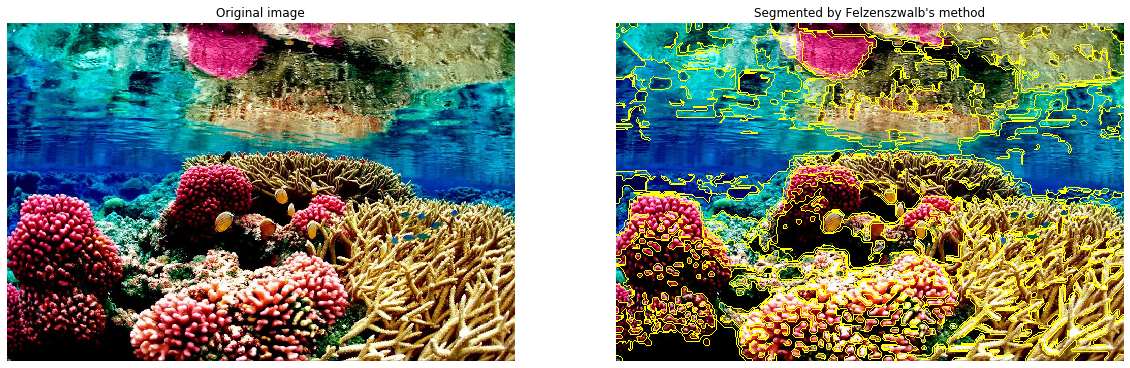

In [15]:
"""
This function allow us to segment an image in different clusters using felzenszwalb function from skimage module

:param image: image to segment (numpy matrix in RGB)
:return: the segemented image
"""
def felzenszwalbs_method(image):
    
    # First we're gonna apply felsenszwalb's efficient graph based algorithm for image segmentation for an RGB image
    # The selection of the parameters its important here...
    #    - the scale parameter represents the size of the clusters.
    #      So if we want a particular sensibility we may select lower numbers.
    #    - the sigma represents the diameter of the gaussian function
    #      used for smoothing the image before the segmentation.
    #    - the min_size is the minimum size of a cluster
    #    - if the multichannel parameter is True, it means that we're taking an image on RGB
    
    segmented_img = segmentation.felzenszwalb(image, scale=200, sigma=3, min_size=50)
    
    # Finally we need to mark all the clusters with a yellow line with mark_boundaries function...
    return segmentation.mark_boundaries(image, segmented_img)

plotter(images=[corals,felzenszwalbs_method(corals)],titles=["Original image", "Segmented by Felzenszwalb's method"],gray=[False,False],rows=1,cols=2)

### Answering questions

As we commented in the code cell we use the felzenszwalb function. The selection of the parameters is important to clustering the image properly:

* The scale parameter represents the size of the clusters. So if we want a particular sensibility we may select lower numbers.
* The sigma represents the diameter of the gaussian function, used for smoothing the image before the segmentation.
* The min_size is the minimum size of a cluster.
* Finally, if the multichannel parameter is True, it means that we're taking an image on RGB

So we were manipulating the sigma and the scale parameters, and finally found that we can separate the image into the correct segments (they which represents a very different shape inside the image), with the values of scale=200 and sigma=3.

The skimage documentation for the felzenszwalb function says that the graph based algoritmh produces an oversegmentation of a multichannel (i.e. RGB) image using a fast, minimum spanning tree based clustering on the image grid.

b) Segment the previous image using SLIC algorithm. Test different parameters in order to obtain a good image segmentation. How does each parameter behave? Upt o your opinion, which are the optimal values? Comment what algorithm is the method based in up to 3 lines.

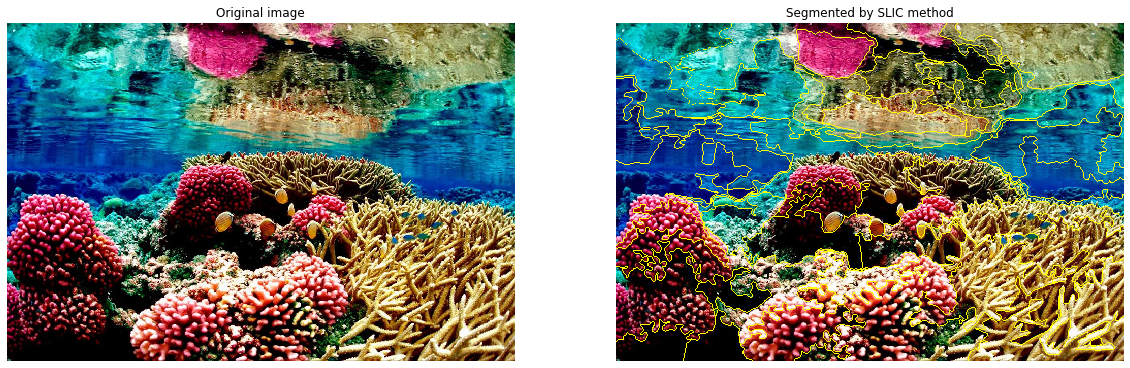

In [16]:
"""
This function allow us to segment an image in different clusters using SLIC function from skimage module

:param image: image to segment (numpy matrix in RGB)
:return: the segemented image
"""
def slic_method(image):
    # Apply SLIC algorithm in order to segment the image introduced as an argument...
    segments_slic = segmentation.slic(image, n_segments=70, sigma=3)
    return segmentation.mark_boundaries(image, segments_slic)

plotter(images=[corals,slic_method(corals)],titles=["Original image", "Segmented by SLIC method"],gray=[False,False],rows=1,cols=2)

### Answering questions

If we look at the documentation of skimage, there is a lot of parameters that behave (more or less) particulary in different things. We've played with two different parameters here, the sigma of the previous smoothing and also the number of segments (n_segments). We can see the image has a lot of elements in different shapes, so for de n_segments we will put a high value in order to distinguish every fragment. Then we don't want a very smoothed image, so we were trying the function for a different values.

Finally we think that the best values for the two previous attributes for this function are:
* n_segments = 70
* sigma = 3

This time, SLIC algorithm for image segmentation generates superpixels by clustering pixels based on their color similarity and proximity in the image plane. A superpixel can be defined as a group of pixels that share common characteristics (like pixel intensity).

c) Plot the original image and the results of both algorithms in a 1x3 subplot. Calculate also the number of segments obtained on the image by each of the algorithms. Comment the differences between each method as well as their advantages and disadvantages.

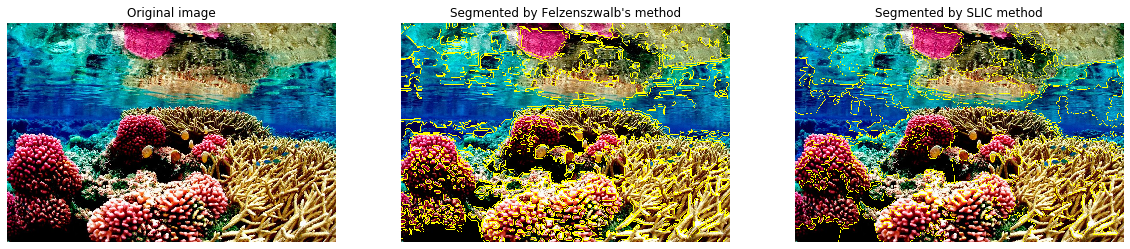

In [25]:
# Plot the results
plotter(images=[corals,felzenszwalbs_method(corals),slic_method(corals)],titles=["Original image","Segmented by Felzenszwalb's method", "Segmented by SLIC method"],gray=[False,False,False],rows=1,cols=3)

In [26]:
# We can calculate the number of segments using unique function (different values on an array) 
# after using segmentation algorithms with the same parameters as in the functions...
felzenszwalbs = segmentation.felzenszwalb(corals, scale=200, sigma=3, min_size=50)
slic = segmentation.slic(corals, n_segments=70, sigma=3)

n_segments_f = len(np.unique(felzenszwalbs))
n_segments_s = len(np.unique(slic))

#Display the data obtained...
print()
print("----------------------------------------------------------------------------------------")
print("The numbers of segments using Felzenszwalb's image segmentation algorithm are: ",n_segments_f)
print("The numbers of segments using SLIC image segmentation algorithm are: ",n_segments_s)
print("----------------------------------------------------------------------------------------")


----------------------------------------------------------------------------------------
The numbers of segments using Felzenszwalb's image segmentation algorithm are:  481
The numbers of segments using SLIC image segmentation algorithm are:  44
----------------------------------------------------------------------------------------


### Answering questions

As we saw on the anterior cell, we are getting a very large number of segments using Felzenszwalb's image segmentation algorithm in contrast to SLIC one. As we saw in theory class every algorithm has its advanatges and disadvantages. So we are going to comment every algorithm pros and cons.

#### Felzenszwalb's image segmentation algorithm
##### Pros
* Simple algorithm based in graphs.
* We can say that because of its simplicity, the algorithm is efficient and fast than others.
* We can select the size of the segments with the "scale" parameter, and also the smoothing on the image with sigma.

##### Cons
* The algorithm is very sensible to a contrast image, so it will separate the shadows as a different object in many cases taking in account the previous smoothing.

#### SLIC image segmentation algorithm
##### Pros
* Simple algorithm basen on K-Means clustering.
* Here we don't have the same problem as before, because we can avoid the contrast on the image using the compactness parameter.

##### Cons
* It is annoying to be selecting the number of clusters every time we need to use this algorithm.